# Wheelbot design

Script to compute the required dimension of the uniwheel robot.


## Rough weight estimate

The weight of the unicycle  is roughly:

360g (2x180g) T-motors Antigravity 6007 KV160

400g (2x200g) Flywheels

200g (4x85g) LiPo Batteries

100g Microcontroller boards + cables

300g 3D printed housing

=> 1400 g Total weight

<img src="attachment:stability_drawing.png" alt="drawing" width="600"/>

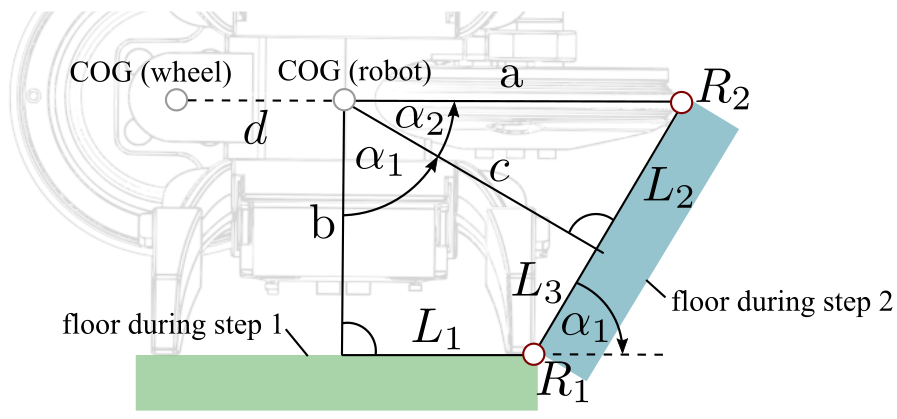

## Housing dimensions

Assume we fix the width of the Wheelbots cube $b$. 
- What should be the cube's side length $2 \cdot L1$?
- What should be the distance $a$ between wheel tip and COG $a$?

If the Wheelbot rotates around $P_1$ the gravitational force has the lever $L_1$.
If the Wheelbot rotates around $P_2$ the gravitational force has the lever $L_2$.

If during standup the Wheelbot does not rotate around a *fixed* point, but instead the point is sliding towards the COG, the required motor torque for standup is smaller than for a fixed rotation point.

1) First determine $L_1$ and $L_2$ such that the intial static torque is the same for both standup maneuvers.

2) Then check if the Wheelbot is stable when $P_1$ and $P_2$ is in contact with the floor.

3) Look at the static torque profile. This is the maximum torque needed for both stand-up maneuvers.


Iteration: 10987 L1:  0.06045019750987549 L2:  0.060447039424826356
alpha_1 [deg]:  57.661   alpha_2[deg]:  32.339
L [m]:  0.06   Max. Torque [Nm]:  0.83
Pushback Torque [Nm]:  0.519


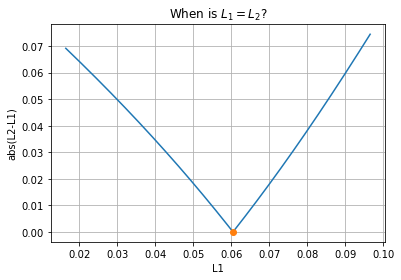

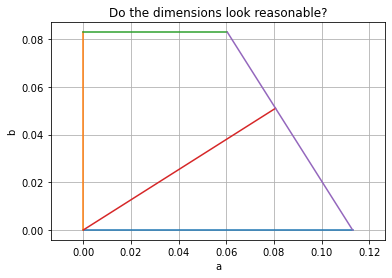

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = 0.113  # Length COG to RP2 (rotation point 2)
b = 0.083  # Width of the uniwheel cube
m = 1.4  # Mass of the uniwheel robot
Fg = m * 9.81  # Gravitational force at COG

# Init an array of potential vlaues of L1
n=20000
L1_array = np.linspace(0.5*a-0.04, 0.5*a+0.04, n)

def function_L2(a, b, L1):
    """
    Computes L2 as a function of a, b, L1
    """
    alpha = np.math.atan2(b, a-L1)
    return a*np.math.cos(alpha)

# Compute L2 that is closest to L1
L2_array = np.zeros((n,)) # Init L2 to zero
L1_best = L1_array[0]
L2_best = function_L2(a, b, L1_array[0])
for i in range(L1_array.shape[0]):
    L2_array[i] = function_L2(a, b, L1_array[i])
    if np.abs(L2_array[i]-L1_array[i]) < np.abs(L2_best-L1_best):
        L1_best = L1_array[i]
        L2_best = L2_array[i]
        i_last = i
print('Iteration:', i_last, 'L1: ', L1_array[i_last], 'L2: ', L2_best)

plt.figure(1)    
plt.plot(L1_array, np.abs(L2_array-L1_array))
plt.plot(L1_array[i_last],np.abs(L2_best-L1_best), linestyle='None', marker='o')
plt.xlabel('L1')
plt.ylabel('abs(L2-L1)')
plt.title('When is $L_1 = L_2$?')
plt.grid()

alpha1 = np.math.atan2(b, a-L1_best) # Angle of first standup maneuver (rad)
alpha2 = np.pi/2 - alpha1 # Angle of second standup maneuver (rad)

plt.figure(2)
plt.title('Do the dimensions look reasonable?')
plt.plot([0,a],[0,0])
plt.plot([0,0],[0,b])
plt.plot([0,L1_best],[b,b])
plt.plot([a-L2_best*np.math.cos(alpha1),0],[L2_best*np.math.sin(alpha1),0])
plt.plot([L1_best, a],[b, 0])
plt.xlabel('a')
plt.ylabel('b')
plt.grid()
plt.axis('equal')

L3 = np.sqrt((a-L1_best)**2 + b**2) - L2_best
c = np.math.sqrt(a**2 - L2_best**2)  # Distance between COG and shortest line from RP1 to RP2

print('alpha_1 [deg]: ', round(np.rad2deg(alpha1),3),'  alpha_2[deg]: ', round(np.rad2deg(alpha2),3))
print('L [m]: ', round(L1_best,3), '  Max. Torque [Nm]: ', round(L1_best*Fg,3))
print('Pushback Torque [Nm]: ', round(L3*Fg,3))

#### Some calculated values
a = 0.090, b = 0.06

alpha1 [deg]:  56.282  alpha2 [deg]:  33.718
E1 [J]:  0.219   E2 [J]:  0.223
L [m]:  0.05   Max. Torque [Nm]:  0.735

---
a = 0.105, b = 0.055

alpha1 [deg]:  52.878   alpha2 [deg]:  37.122
E1 [J]:  0.423   E2 [J]:  0.313
L [m]:  0.063   Max. Torque [Nm]:  0.932

---

a = 0.105, b = 0.06

alpha1 [deg]:  54.1   alpha2 [deg]:  35.9
E1 [J]:  0.369   E2 [J]:  0.294
L [m]:  0.062   Max. Torque [Nm]:  0.906

---

**a = 0.105, b = 0.07**

alpha1 [deg]:  56.283   alpha2 [deg]:  33.717
E1 [J]:  0.255   E2 [J]:  0.26
L [m]:  0.058   Max. Torque [Nm]:  0.858


---

**a = 0.113, b = 0.083**

alpha1 [deg]:  57.661   alpha2 [deg]:  32.339
E1 [J]:  0.171   E2 [J]:  0.241
L [m]:  0.06   Max. Torque [Nm]:  0.83

---

a = 0.15, b = 0.08

alpha1 [deg]:  53.13   alpha2 [deg]:  36.87
E1 [J]:  0.589   E2 [J]:  0.441
L [m]:  0.09   Max. Torque [Nm]:  1.324

## Check if standup works

Max. motor speed (unloaded): 4900 rpm (according to t-motors website)
Motor speed (with load): 2700 rpm (from experiment)

Nominal max. motor torque: 1.3 Nm (according to t-motors website)

Max. Inertia of wheel with flywheel having 230g mass and 10cm diameter: 300 kgmm^2

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

class wheelbot25(object):
    """
    Parameters of wheelbt v2.5
    """

    def __init__(self):
        self.B_p1 = [-0.048, -0.048, 0.119]
        self.B_p2 = [0.048, 0.048, 0.119]
        self.B_p3 = [0.048, -0.048, -0.004]
        self.B_p4 = [-0.048, 0.048, -0.004]

        #Dimensions in m
        self.R = 0.052 # wheel radius of disc
        self.B = 0.166 # Width of cube in x/y direction
    
        self.d = 0.058 # Distance between wheel joint and chasis COG
        self.a = 0.110 # Half height of wheelbot
        
        #self.a = 0.106 # Half height of wheelbot
        #self.d = 0.054
        
        self.b = self.B/2
        self.L = 0.0604 # Initial lever of gravity force L1=l2

        assert  self.a == self.R + self.d
        assert  self.b == self.B/2
        assert  self.L < self.a and self.L < self.b
        
        # Masses and inertias
        self.M1 = 0.3 # Rolling wheel mass in kg
        self.M2 = 0.8 # Chasis mass in kg
        self.M3 = 0.3 # Reaction wheel mass in kg

        # Rolling wheel inertias
        self.I1x = 0.000259 # pointing in drive direction
        self.I1y = 0.000503 # Rotational DOF inertia in kg * m2
        self.I1z = 0.000259

        # Chasis Inertias
        self.I2x = 0.001746 # Roll chasis inertia
        self.I2y = 0.00181 # Pitch chasis inertia
        self.I2z = 0.001585 # Yaw chasis inertia

        # Reaction wheel Inertias
        self.I3x = 0.000503 # Rotational DOF Inertia
        self.I3y = 0.000259
        self.I3z = 0.000259 # Pointing'up'
        
wb = wheelbot25()

In [3]:
from scipy.integrate import odeint

m_total = wb.M1 + wb.M2 + wb.M3

def pythag(a, b):
    """Compute hypotenuse via pythagoras"""
    return np.sqrt(a**2 + b**2)

# Index 1 - Rolling wheel
# Index 2 - Chassis
# Index 3 - Reaction wheel

# Total inertia - standup step 1
s1 = wb.M1*wb.b**2 # Approximately
s2 = wb.M2*pythag(wb.L, wb.b)**2
s3 = wb.M3*pythag(wb.L + wb.d, wb.b)**2
I_tot1 = wb.I1x + wb.I2x + wb.I3x + s1 + s2 + s3 # Inertia at R1

# Total inertia - standup step 2
s1 = wb.M1*wb.R**2
s2 = wb.M2*wb.a**2
s3 = wb.M3*(wb.a+wb.d)**2 
I_tot2 = wb.I1x + wb.I2x + wb.I3x + s1 + s2 + s3 # Inertia at R1

def wb_ODE(y, t, I_tot, I_wheel, l_cog, m_tot):

    theta, d_theta, omega = y
    
    T0 = 1.2 # Stall torque
    omega0 = 282 # Max motor rate under load 282rad/s = 2700 RPM
    T=T0
    """
    # If motor would be subject to back-emf
    if omega < 0:
        T = T0
    else:
        T = T0 - (omega/omega0)*T0
    """ 
    Mg = m_tot * 9.81 * l_cog * np.sin(theta)
    dd_theta = (Mg - T) / I_tot
    d_omega = T / I_wheel
    
    dydt = [d_theta, dd_theta, d_omega]
    return dydt



The first step of the standup can be simplified to a reaction wheel pendulum with inertia I_tot1 and generalized coordinate $\theta_1$

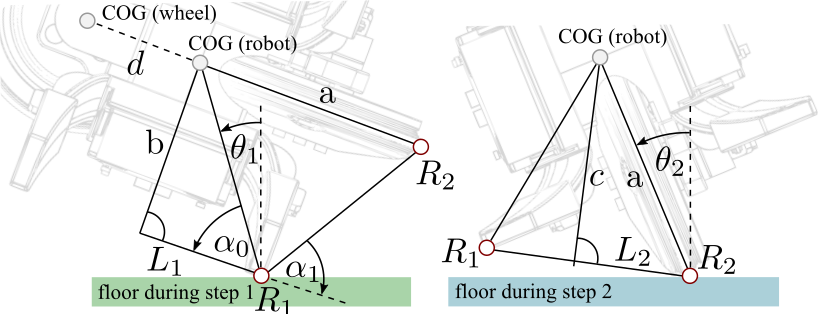


Limits of $\theta_1$ in deg: 36.04378816176755   -21.594429644205512


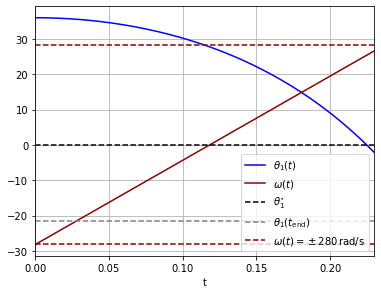

Limits of $\theta_2$ in deg: 32.33913395932972   0.0


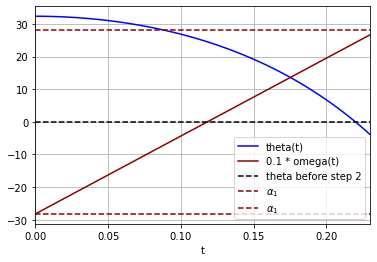

In [5]:
import seaborn as sb


# Standup step 1
lcog1 = pythag(wb.L, wb.b)
alpha0 = np.arctan2(wb.b, wb.L)
#theta_end = np.pi/2 - alpha0 - alpha1
#print(theta_end)
theta_start1 = np.pi/2 - alpha0
theta_end1 = -np.arctan2(L3, c)
print(r'Limits of $\theta_1$ in deg:', np.rad2deg(theta_start1), ' ', np.rad2deg(theta_end1))

omega0 = 282
y0 = [theta_start1, 0, -omega0]
t_end1 = 0.23
t1 = np.linspace(0, t_end1, 101)
omega_limit = 0.1*np.asarray([omega0] * 101)
sol1 = odeint(wb_ODE, y0, t1, args=(I_tot1, wb.I3x, lcog1, m_total))

#plt.fill_between(t, -omega_limit, omega_limit, color='gray', alpha=0.5) #lw=2
plt.plot(t1, np.rad2deg(sol1[:, 0]), 'b', label=r'$\theta_1(t)$')
#plt.plot(t, np.rad2deg(0.1 * sol1[:, 1]), 'g', label='0.1 * d_theta(t)')
plt.plot(t1, 0.1*sol1[:, 2], 'darkred', label='$\omega(t)$')

plt.axhline(y=0, color='k', linestyle='--', label=r'$\theta_1^{\star}$')
plt.axhline(y=np.rad2deg(theta_end1), color='gray', linestyle='--', label=r'$\theta_1(t_{\mathrm{end}})$')

plt.axhline(y=0.1*-omega0, color='darkred', linestyle='--', label=r'$\omega(t)=\pm 280\, \mathrm{rad/s}$')
plt.axhline(y=0.1*omega0, color='darkred', linestyle='--')

plt.margins(x=0)
plt.tight_layout(rect=[0,0,.9,1]) 
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

# Standup step 2
lcog2 = wb.a
theta_start2 = alpha2
theta_end2 = 0
y0 = [theta_start2, 0, -282]
t_end2 = 0.23
t2 = np.linspace(0, t_end2, 101)
print(r'Limits of $\theta_2$ in deg:', np.rad2deg(theta_start2), ' ', np.rad2deg(theta_end2))

sol2 = odeint(wb_ODE, y0, t2, args=(I_tot2, wb.I3x, lcog2, m_total))

plt.plot(t2, np.rad2deg(sol2[:, 0]), 'b', label='theta(t)')
#plt.plot(t, np.rad2deg(0.1 * sol2[:, 1]), 'g', label='0.1 * d_theta(t)')
plt.plot(t2, 0.1*sol2[:, 2], 'darkred', label='0.1 * omega(t)')

plt.axhline(y=np.rad2deg(theta_end2), color='k', linestyle='--', label='theta before step 2')

#plt.fill_between(t, -omega_limit, omega_limit, color='gray', alpha=0.5) #lw=2
plt.axhline(y=0.1*-omega0, color='darkred', linestyle='--', label=r'$\alpha_1$')
plt.axhline(y=0.1*omega0, color='darkred', linestyle='--', label=r'$\alpha_1$')

plt.margins(x=0)
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.tight_layout()
plt.show()

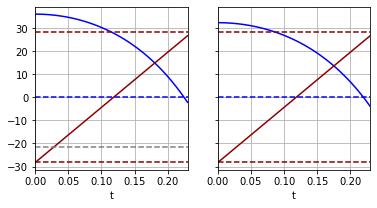

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
#fig.suptitle('Horizontally stacked subplots')

ax1.plot(t1, np.rad2deg(sol1[:, 0]), 'b', label=r'$\theta_1(t)$')
ax1.plot(t1, 0.1*sol1[:, 2], 'darkred', label='$\omega(t)$')

ax1.axhline(y=0, color='blue', linestyle='--', label=r'$\theta_1^{\star}$')
ax1.axhline(y=np.rad2deg(theta_end1), color='gray', linestyle='--', label=r'$\theta_1(t_{\mathrm{end}})$')

ax1.axhline(y=0.1*-omega0, color='darkred', linestyle='--', label=r'$\omega(t)=\pm 280\, \mathrm{rad/s}$')
ax1.axhline(y=0.1*omega0, color='darkred', linestyle='--')

ax1.margins(x=0)
ax1.set_xlabel('t')
ax1.grid()

ax2.plot(t2, np.rad2deg(sol2[:, 0]), 'b', label='theta(t)')
ax2.plot(t2, 0.1*sol2[:, 2], 'darkred', label='0.1 * omega(t)')

ax2.axhline(y=np.rad2deg(theta_end2), color='blue', linestyle='--', label='theta before step 2')

ax2.axhline(y=0.1*-omega0, color='darkred', linestyle='--', label=r'$\alpha_1$')
ax2.axhline(y=0.1*omega0, color='darkred', linestyle='--', label=r'$\alpha_1$')

ax2.margins(x=0)
ax2.set_xlabel('t')
ax2.grid()


plt.savefig('standup_test.pdf')  

plt.show()



## Estimate battery capacity and weight

1) Use wheelbot dimensions to check the energy required for one standup

2) Determine the required battery capacity, choose a battery, and repeat above computation respecting the battery weight.


**T-motors Antigravity 6007 KV160**

Nominal current = 18 A

Operating voltage = 24 V

**Some useful formulas:**

Energy [Joul, kgm^2/s^2] = capacity (As) * voltage (Volts) 

1 Ah = 3600 As (1C = As)

Capacity (mAh) = (1000/3600) * Energy (Joul) / Voltage (V)

In [ ]:
n_standups = 100

# For the potential energy the COG moves during first standup from b to c and second standup from c to a
d1 = c - b # Height difference that the COG travels of first standup step
d2 = a - c
E1 = d1 * Fg
E2 = d2 * Fg

print('d1 [m]:', round(d1,3), ' d2 [m]:', round(d2,3))
print('E1 [J]: ', round(E1,3),'  E2 [J]: ', round(E2,3))

efficiency_factor = 0.6 # 60% of Energy gets turned into rotational torque
E_standup_mech = (1/efficiency_factor)*(E1 + E2)*n_standups
E_standup_mech_rot = 0.5*0.001746*(260)**2


I_max = 16  # Max motor current
V_motor = 24 # Motor voltage

t_standup = 0.6
E_standup_elec = 0.4 * V_motor * I_max * t_standup * n_standups  
# The 0.4 is an approximation to account for a reduce in torque over time during the standup

I_balancing = 5 # Average current during stabilization of TWO MOTORS
t_balancing = 600 # Time uniwheel runs in stabilization mode in seconds
E_balancing = I_balancing * V_motor * t_balancing

capacity_As = (E_standup_elec + E_balancing) / V_motor
capacity_mAh = (1000/3600)*capacity_As

print('Energy (Standup, mechanical est.) [J]: ', round(E_standup_mech, 1))
print('Energy (Standup, rot est.) [J]: ', round(E_standup_mech_rot, 1))
print('Energy (Standup, electrical est.) [J]: ', round(E_standup_elec, 1))
print('Energy (Balancing) [J]: ', E_balancing)
print('Battery capacity [mAh]: ', round(capacity_mAh,1))



### LiPo battery examples
#### 3S:

164g (4x42g), 13x54x29 mm, 11.1V, 450mAh (Bestell-Nr.: 1644359 - NA)

180g (4x45g), 21x63x16 mm, 11.1V, 450mAh (Bestell-Nr.: 1644347 - NA)

170g (2x85g), 24x59x30 mm, 11.1V, 850mAh (Bestell-Nr.: 1644357 - NA)

170g (2x85g), 24x59x30 mm, 11.1V, 850mAh (Bestell-Nr.: 1784869 - NA)

#### 4S:

220g (4x55g), 27x45x24 mm, 14.8V, 450mAh (Bestell-Nr.: 1542427 - NA)

**232g (4x58g), 27x65x17 mm, 14.8V, 450mAh (Bestell-Nr.: 1644348 - NA)**

220g (2x110g), 33x58x30 mm, 14.8V, 850mAh (all the same)